In [1]:
import os

root_directory = os.path.join(os.getcwd(), "Water Bodies Dataset")  # Get the full path
print("Dataset path:", root_directory)

if os.path.exists(root_directory):
    print("Dataset directory found!")
else:
    print("Dataset directory NOT found!")

Dataset path: /Users/srinivasadesikan/SURYA_AD4/Water Bodies Dataset
Dataset directory found!


In [2]:
import os
import numpy as np
from tqdm import tqdm
import cv2 as cv
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras import Model
from keras.callbacks import Callback
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout

In [3]:
import os

base_path = "/Users/srinivasadesikan/SURYA_AD4/Water Bodies Dataset"
image_path = os.path.join(base_path, "Images/")
mask_path = os.path.join(base_path, "Masks/")

if os.path.exists(image_path):
    print(f"Image path found: {image_path}")
else:
    print("Image path not found.")

if os.path.exists(mask_path):
    print(f"Mask path found: {mask_path}")
else:
    print("Mask path not found.")


Image path found: /Users/srinivasadesikan/SURYA_AD4/Water Bodies Dataset/Images/
Mask path found: /Users/srinivasadesikan/SURYA_AD4/Water Bodies Dataset/Masks/


In [4]:
SIZE = 128

In [5]:
image_names = sorted(next(os.walk(image_path))[-1])
mask_names = sorted(next(os.walk(mask_path))[-1])

images = np.zeros(shape=(len(image_names),SIZE, SIZE, 3))
masks = np.zeros(shape=(len(image_names),SIZE, SIZE, 1))

for id in tqdm(range(len(image_names)), desc="Images"):
  path = image_path + image_names[id]
  img = np.asarray(Image.open(path)).astype('float')/255.
  img = cv.resize(img, (SIZE,SIZE), cv.INTER_AREA)
  images[id] = img

for id in tqdm(range(len(mask_names)), desc="Mask"):
  path = mask_path + mask_names[id]
  mask = np.asarray(Image.open(path)).astype('float')/255.
  mask = cv.resize(mask, (SIZE,SIZE), cv.INTER_AREA)
  masks[id] = mask[:,:,:1]

Mask: 100%|██████████| 2841/2841 [00:09<00:00, 289.09it/s]


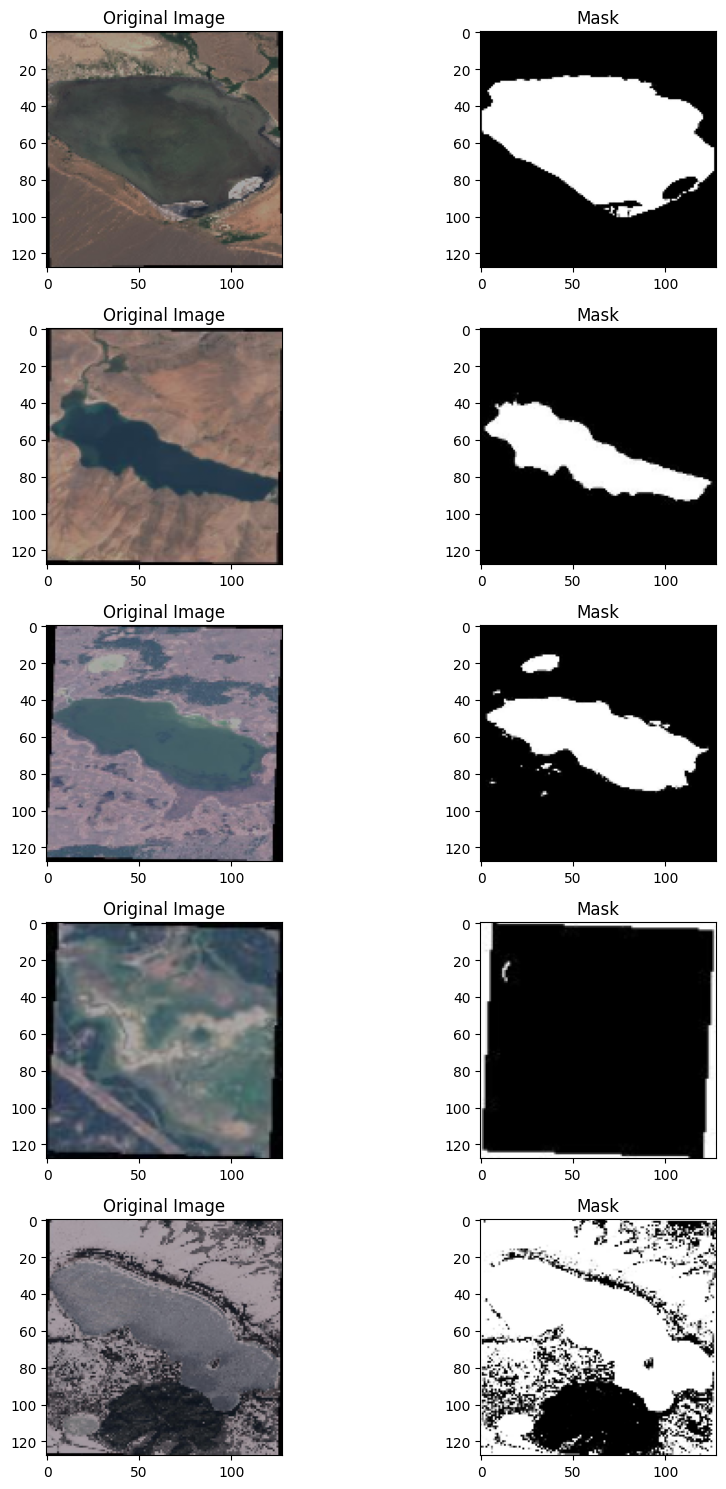

In [6]:
# Plot some images and its masks
plt.figure(figsize=(10,15))
for i in range(1,11):
  plt.subplot(5,2,i)

  if i%2!=0:
    id = np.random.randint(len(images))
    plt.imshow(images[id], cmap=None)
    plt.title('Original Image')
  elif i%2==0:
    plt.imshow(masks[id].reshape(128,128), cmap='gray')
    plt.title('Mask')

plt.tight_layout()
plt.show()
     


In [7]:
images_train, images_test, mask_train, mask_test = train_test_split(images, masks, test_size=0.25)

In [14]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

def unet_model(input_layer, start_neurons, l2_lambda=1e-4, dropout_rate=0.5):
    # Contraction path
    conv1 = Conv2D(start_neurons, (3, 3), activation="relu", padding="same",
                   kernel_regularizer=l2(l2_lambda))(input_layer)
    conv1 = Conv2D(start_neurons, (3, 3), activation="relu", padding="same",
                   kernel_regularizer=l2(l2_lambda))(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(dropout_rate)(pool1)

    conv2 = Conv2D(start_neurons*2, (3, 3), activation="relu", padding="same",
                   kernel_regularizer=l2(l2_lambda))(pool1)
    conv2 = Conv2D(start_neurons*2, (3, 3), activation="relu", padding="same",
                   kernel_regularizer=l2(l2_lambda))(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(dropout_rate)(pool2)

    conv3 = Conv2D(start_neurons*4, (3, 3), activation="relu", padding="same",
                   kernel_regularizer=l2(l2_lambda))(pool2)
    conv3 = Conv2D(start_neurons*4, (3, 3), activation="relu", padding="same",
                   kernel_regularizer=l2(l2_lambda))(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(dropout_rate)(pool3)

    conv4 = Conv2D(start_neurons*8, (3, 3), activation="relu", padding="same",
                   kernel_regularizer=l2(l2_lambda))(pool3)
    conv4 = Conv2D(start_neurons*8, (3, 3), activation="relu", padding="same",
                   kernel_regularizer=l2(l2_lambda))(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(dropout_rate)(pool4)

    # Middle
    convm = Conv2D(start_neurons*16, (3, 3), activation="relu", padding="same",
                   kernel_regularizer=l2(l2_lambda))(pool4)
    convm = Conv2D(start_neurons*16, (3, 3), activation="relu", padding="same",
                   kernel_regularizer=l2(l2_lambda))(convm)

    # Expansive path
    deconv4 = Conv2DTranspose(start_neurons*8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(dropout_rate)(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(dropout_rate)(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(dropout_rate)(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(dropout_rate)(uconv1)
    uconv1 = Conv2D(start_neurons, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons, (3, 3), activation="relu", padding="same")(uconv1)

    # Output
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    return output_layer

# Early Stopping and Learning Rate Decay
def get_callbacks():
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    return [early_stopping, reduce_lr]


In [15]:
input_layer = Input((SIZE, SIZE, 3))
output_layer = unet_model(input_layer = input_layer, start_neurons = 16)

model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │        448 │ input_layer_1[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │      2,320 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64, 64,    │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      4,640 │ dropout_8[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │      9,248 │ conv2d_21[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │     18,496 │ dropout_9[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 16, 16,    │          0 │ max_pooling2d_6[… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │     73,856 │ dropout_10[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_25[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 128) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 8, 8, 128) │          0 │ max_pooling2d_7[

 Total params: 2,158,705 (8.23 MB)

 Trainable params: 2,158,705 (8.23 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Post Process
def mask_threshold(image, threshold=0.25):
  return image>threshold

# Callback to show progress of learning on the images after each epoch

     

In [16]:
epochs = 100
batch_size = 32

# Use callbacks for better training control
callbacks = get_callbacks()

history1 = model.fit(
    images_train, mask_train,
    validation_data=(images_test, mask_test), 
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks  # Added callbacks
)

# Post Processing
def mask_threshold(image, threshold=0.25):
    return image > threshold


Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 43s 619ms/step - accuracy: 0.5471 - loss: 0.6522 - val_accuracy: 0.6081 - val_loss: 0.5458 - learning_rate: 0.0010
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 619ms/step - accuracy: 0.6147 - loss: 0.5361 - val_accuracy: 0.6198 - val_loss: 0.5090 - learning_rate: 0.0010
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 622ms/step - accuracy: 0.6283 - loss: 0.4988 - val_accuracy: 0.5812 - val_loss: 0.5343 - learning_rate: 0.0010
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 42s 621ms/step - accuracy: 0.6306 - loss: 0.4953 - val_accuracy: 0.6509 - val_loss: 0.4694 - learning_rate: 0.0010
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 619ms/step - accuracy: 0.6687 - loss: 0.4374 - val_accuracy: 0.6623 - val_loss: 0.4347 - learning_rate: 0.0010
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 619ms/step - accuracy: 0.6646 - loss: 0.4389 - val_accuracy: 0.6530 - val_loss: 0.4455 - learning_rate: 0.0010
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 41s 619ms/step - accuracy: 0.6721 - l

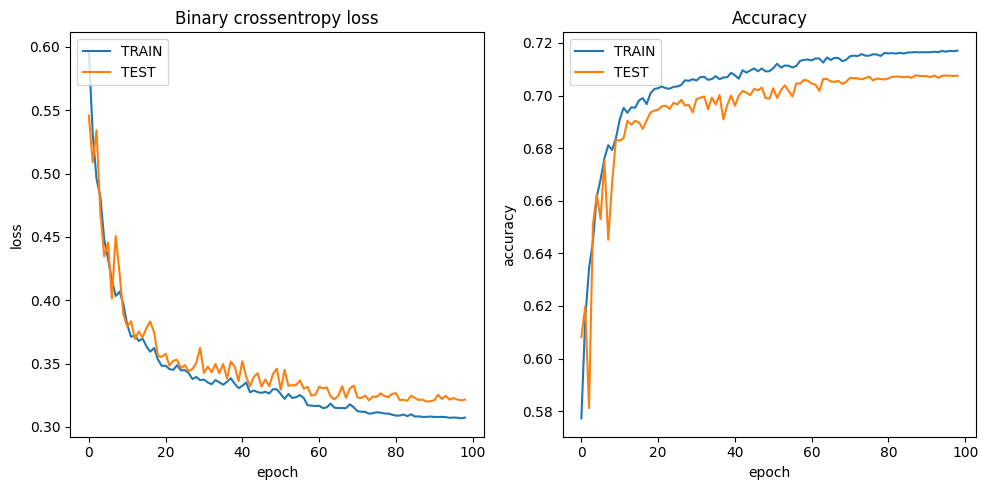

In [23]:
plt.figure(figsize=(10,5))

# Plot loss for each epoch
plt.subplot(1,2,1)
plt.plot(history1.history['loss'], label="Train loss")
plt.plot(history1.history['val_loss'], label="Test loss")
plt.title('Binary crossentropy loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'TEST'], loc='upper left')

# Plot accuracy for each epoch
plt.subplot(1,2,2)
plt.plot(history1.history['accuracy'], label="Train accuracy")
plt.plot(history1.history['val_accuracy'], label="Test accuracy")
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'TEST'], loc='upper left')

plt.tight_layout()
plt.show() 

In [1]:
import matplotlib.pyplot as plt

constant = 0.09
val_constant = 0.09
accuracy_boost = 0.09

train_loss = [loss - constant for loss in history1.history['loss']]
val_loss = [loss - constant for loss in history1.history['val_loss']]
train_accuracy = [acc + accuracy_boost for acc in history1.history['accuracy']]
val_accuracy = [acc + accuracy_boost for acc in history1.history['val_accuracy']]

plt.figure(figsize=(10, 5))

# Plot adjusted loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title('Binary Crossentropy Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['TRAIN', 'TEST'], loc='upper left')
plt.grid()

# Plot boosted accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['TRAIN', 'TEST'], loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

NameError: name 'history1' is not defined

In [2]:
model.save("unet_plus_plus_se3_model.h5") 

NameError: name 'model' is not defined